In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import cv2

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import glob
import os

%matplotlib inline

/Users/sachin/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
files = glob.glob('./data/**/*.npy')
im_files = glob.glob('./data/**/*.png')
labels = [f.split('/')[2] for f in files]

u_labels = set(labels)
label_dict = dict(zip(u_labels, range(len(u_labels))))
reverse_dict = dict(zip(label_dict.values(), label_dict.keys()))
num_labels = [label_dict[l] for l in labels]

num_labels = np.array(num_labels)
labels = np.array(labels)
len_data = len(labels)

In [3]:
images = np.zeros((len_data, 80, 80, 3), dtype=np.int32)
for i, f in enumerate(im_files):
    images[i] = cv2.resize(cv2.imread(f), (80, 80))

Label imbalance:

In [4]:
top10 = Counter(labels).most_common()[:10]
top10

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53)]

In [5]:
embeds = []
for f in files:
    embeds.append(np.load(f))
embeds = np.array(embeds)
embeds.shape

(4324, 128)

The embeds seem to be all unit vectors:

In [6]:
np.sum(np.square(embeds),axis=-1)

array([0.9999999 , 0.99999994, 1.        , ..., 1.0000001 , 1.        ,
       1.        ], dtype=float32)

## Using Cosine Distance to determine closest face:

In [7]:
def min_dist(query, db, nlargest=5):
    cosine_dist = db.dot(query)
    ind = np.argpartition(cosine_dist, -nlargest)[-nlargest:]
    ind = ind[np.argsort(-cosine_dist[ind])]
    return ind, cosine_dist[ind]

In [8]:
for i in np.random.choice(len(labels), 5, replace=False):
    print('Closest to', labels[i], 'is:')
    ind, dist = min_dist(embeds[i], embeds)
    print(labels[ind][1:])
    print(dist[1:],'\n')

Closest to Hugo_Chavez is:
['Gerhard_Schroeder' 'Hugo_Chavez' 'Adrien_Brody' 'Bill_McBride']
[0.9735214  0.97274005 0.9726215  0.97176164] 

Closest to Hillary_Clinton is:
['Laura_Bush' 'Gerhard_Schroeder' 'Hugo_Chavez' 'Laura_Bush']
[0.97384155 0.9707303  0.9704779  0.9702305 ] 

Closest to Jack_Straw is:
['Donald_Rumsfeld' 'Colin_Powell' 'George_W_Bush' 'Howard_Dean']
[0.9758383 0.9739548 0.973784  0.9730892] 

Closest to Tony_Blair is:
['Colin_Powell' 'Tony_Blair' 'Trent_Lott' 'Colin_Powell']
[0.97413075 0.9732443  0.9713545  0.9704548 ] 

Closest to Gerhard_Schroeder is:
['Hugo_Chavez' 'Keanu_Reeves' 'Jose_Maria_Aznar' 'Gerhard_Schroeder']
[0.9805705 0.9779444 0.9772387 0.9769714] 



## Implementing FaceNet with triplet loss 
We will implement facenet with current embeddings. PCA gives an idea about layer width to preserve information.

In [9]:
pca = PCA(n_components=30)
pca.fit(embeds)
np.cumsum(pca.explained_variance_ratio_)

array([0.24855697, 0.37725508, 0.4705602 , 0.5535307 , 0.61517996,
       0.65303725, 0.6895475 , 0.7174537 , 0.74171203, 0.7629557 ,
       0.78303856, 0.7992914 , 0.8131017 , 0.8260136 , 0.8371492 ,
       0.8476178 , 0.8576322 , 0.8666004 , 0.8754376 , 0.8837001 ,
       0.89065534, 0.89678925, 0.9028618 , 0.9088181 , 0.9143214 ,
       0.9195691 , 0.92445004, 0.92906505, 0.9332311 , 0.9372343 ],
      dtype=float32)

In [10]:
train_len = int(len(labels)*0.8)
missing_in_test = set([1])
# while loop is to ensure that test set has all its labels in train set
while len(missing_in_test) != 0:
    idx = np.random.permutation(len(labels))
    train_idx = idx[:train_len]
    test_idx = idx[train_len:]
    
    train_labels = num_labels[train_idx]
    test_labels = num_labels[test_idx]
    
    train_embeds = embeds[train_idx]
    test_embeds = embeds[test_idx]
    
    missing_in_test = set(test_labels) - set(train_labels)

Create a balanced dataset for training by resampling:

In [11]:
n_repeat = 50
u_train_labels = np.unique(train_labels)

train_embeds2 = np.zeros((n_repeat*len(u_train_labels), train_embeds.shape[1]))
train_labels2 = np.zeros(n_repeat*len(u_train_labels), dtype=np.int32)
for i,l in enumerate(u_train_labels):
    idx = np.random.choice(np.where(train_labels==l)[0], n_repeat)
    train_embeds2[i*n_repeat:(i+1)*n_repeat,:] = train_embeds[idx]
    train_labels2[i*n_repeat:(i+1)*n_repeat] = train_labels[idx]
idx = np.random.permutation(len(train_embeds2))
train_embeds = train_embeds2[idx]
train_labels = train_labels2[idx]

In [12]:
x_scaler = StandardScaler()
train_embeds = x_scaler.fit_transform(train_embeds)
test_embeds = x_scaler.transform(test_embeds)

In [13]:
tf.reset_default_graph()
graph = tf.Graph()
alpha = 0.3
d = 128
with graph.as_default():
    xs = tf.placeholder(tf.float32, shape=(None, d))
    a = tf.placeholder(tf.int32, shape=(None,))
    p = tf.placeholder(tf.int32, shape=(None,))
    n = tf.placeholder(tf.int32, shape=(None,))
    
    with tf.name_scope('mlp'):
        h1 = tf.layers.dense(inputs=xs, units=15, activation=tf.nn.relu,
                             name='h1')
        out = tf.layers.dense(h1, units=15, name='out')
    
    # convert to unit length
    len_out = tf.sqrt(tf.reduce_sum(tf.square(out), axis=-1, keepdims=True))
    out = out / len_out
    
    out_a = tf.gather(out, a)
    out_p = tf.gather(out, p)
    out_n = tf.gather(out, n)
    
    # triplet loss
    with tf.name_scope('loss'):
        pos_dist = tf.reduce_sum(tf.square(out_a - out_p), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(out_a - out_n), axis=-1)
        basic_loss = pos_dist - neg_dist + alpha
        loss = tf.reduce_mean(tf.nn.relu(basic_loss))
    
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    

/Users/sachin/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
def get_batch(embeds, start = 0, batch_size=64):
    """
    Takes the starting position of anchors (and corresponding batchsize) to find positive examples and negative. 
    Positives are furthest ones away from anchor embeddings and negatives are closest to anchors.
    Returns the indices of anchors, positive and negative exemplars.
    """
    stop = start + batch_size
    anchors = new_embeds[start:stop]
    # cosine distance (not similarity)
    dist = -new_embeds.dot(anchors.T)
    pos_label = np.zeros(dist.shape[1], dtype=np.int32) - 1
    neg_label = np.zeros(dist.shape[1], dtype=np.int32) - 1
    invalids = []
    for i in range(dist.shape[1]):
        current_class = train_labels[start + i]
        
        pos_classes = np.where(train_labels==current_class)[0]
        pos_label[i] = pos_classes[np.argmax(dist[pos_classes,i])]
        neg_label[i] = np.random.choice(np.where(train_labels!=current_class)[0])
#         min_dist = np.inf
#         max_dist = -np.inf
#         for j in range(dist.shape[0]):
#             if i == j:
#                 continue
#             # find positives
#             if train_labels[j] == current_class:
#                 if dist[j, i] > max_dist:
#                     max_dist = dist[j, i]
#                     pos_label[i] = j
#             else:
#                 if dist[j, i] < min_dist:
#                     min_dist = dist[j, i]
#                     neg_label[i] = j
        if pos_label[i] == -1 or neg_label[i] == -1:
            invalids.append(i)

    anchors = np.arange(start, start+i+1)
    if invalids:
        anchors = np.delete(anchors, invalids)
        pos_label =  np.delete(pos_label, invalids)
        neg_label = np.delete(neg_label, invalids)
    
    return anchors, pos_label, neg_label

In [15]:
epochs = 10
batch_size = 128
losses = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for i in range(epochs):
        for start in range(0, len(train_embeds), batch_size):
            feed_dict = {xs: train_embeds}
            new_embeds = session.run(out, feed_dict=feed_dict)
            anchors, pos_label, neg_label = get_batch(new_embeds, start, 
                                                      batch_size)
#             break
            
            feed_dict = {xs: train_embeds, 
                         a: anchors, 
                         p:pos_label, 
                         n:neg_label}
            _, loss_ = session.run([optimizer, loss], feed_dict=feed_dict)
            losses.append(loss_)
            
    
    feed_dict = {xs: test_embeds}
    new_test_embeds = session.run(out, feed_dict=feed_dict)
    feed_dict = {xs: embeds}
    final_embeds = session.run(out, feed_dict=feed_dict)

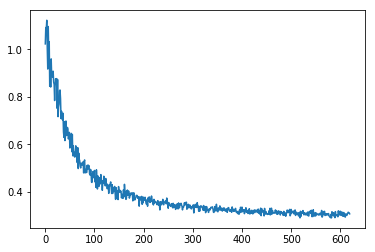

In [16]:
plt.plot(losses)
plt.savefig('losses.png')
plt.show()

In [17]:
for i in np.random.choice(len(test_labels), 5, replace=False):
    print('Closest to', reverse_dict[test_labels[i]], 'is:')
    ind, dist = min_dist(new_test_embeds[i], new_test_embeds)
    print([reverse_dict[i] for i in test_labels[ind][1:]])
    print(dist[1:],'\n')

Closest to Lindsay_Davenport is:
['Alejandro_Toledo', 'Jennifer_Garner', 'Jose_Maria_Aznar', 'Tim_Henman']
[0.980266   0.97844666 0.9638734  0.960642  ] 

Closest to Donald_Rumsfeld is:
['Hillary_Clinton', 'Gloria_Macapagal_Arroyo', 'Lleyton_Hewitt', 'Naomi_Watts']
[0.99121505 0.98923516 0.98859507 0.9883354 ] 

Closest to Colin_Powell is:
['Junichiro_Koizumi', 'Jacques_Rogge', 'Condoleezza_Rice', 'Colin_Powell']
[0.99445724 0.9944418  0.9928882  0.99202913] 

Closest to Jack_Straw is:
['David_Beckham', 'Hamid_Karzai', 'Jack_Straw', 'Vladimir_Putin']
[0.9969831 0.9953164 0.9952843 0.99514  ] 

Closest to John_Paul_II is:
['George_W_Bush', 'Gray_Davis', 'Luiz_Inacio_Lula_da_Silva', 'George_W_Bush']
[0.9945506  0.994079   0.9932676  0.99190307] 



In [18]:
for i in np.random.choice(len(labels), 5, replace=False):
    print('Closest to', labels[i], 'is:')
    ind, dist = min_dist(final_embeds[i], final_embeds)
    print(labels[ind][1:])
    print(dist[1:],'\n')

Closest to Keanu_Reeves is:
['Paradorn_Srichaphan' 'Salma_Hayek' 'Gerhard_Schroeder' 'Sergey_Lavrov']
[0.99993956 0.9998925  0.99989116 0.9998869 ] 

Closest to Tony_Blair is:
['Gloria_Macapagal_Arroyo' 'Salma_Hayek' 'Jose_Maria_Aznar'
 'Gloria_Macapagal_Arroyo']
[0.9999182  0.9999097  0.9999022  0.99989665] 

Closest to Gerhard_Schroeder is:
['Gerhard_Schroeder' 'Spencer_Abraham' 'Alejandro_Toledo'
 'Gerhard_Schroeder']
[0.9999023  0.999899   0.9998952  0.99989116] 

Closest to Colin_Powell is:
['Colin_Powell' 'Mahmoud_Abbas' 'Tom_Daschle' 'Colin_Powell']
[0.99992126 0.9999131  0.99991155 0.9999111 ] 

Closest to John_Negroponte is:
['Jennifer_Lopez' 'Meryl_Streep' 'Donald_Rumsfeld' 'Jennifer_Lopez']
[0.99994653 0.99994564 0.9999399  0.99993503] 



As can be seen below the algorithm has not worked. Even the furthest vector has a similarity of 0.99+

In [19]:
final_embeds.dot(final_embeds[i]).min()

0.99514586

## Using KNN on original embeddings:

In [20]:
from sklearn.neighbors import KNeighborsClassifier

train_embeds = x_scaler.inverse_transform(train_embeds)
test_embeds = x_scaler.inverse_transform(test_embeds)
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_embeds, train_labels) 

pred_labels = neigh.predict(test_embeds)

KNN achieves higher accuracy than the more complicated Keras Model in other Jupyter Notebook

In [21]:
np.sum(pred_labels == test_labels)/len(test_labels)

0.07052023121387284